*Problem Statement*

With a set of 4 hydrophones located in a rectangle around the submarine center, how much does noise affect the predictions of the pinger heading?

In [111]:
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import norm
import numpy as np
import math
import sympy

We can expect a certain level of noise coming into this stage of the pipeline. For simulation purposes we will assume the detected times are normally distributed around their true value.

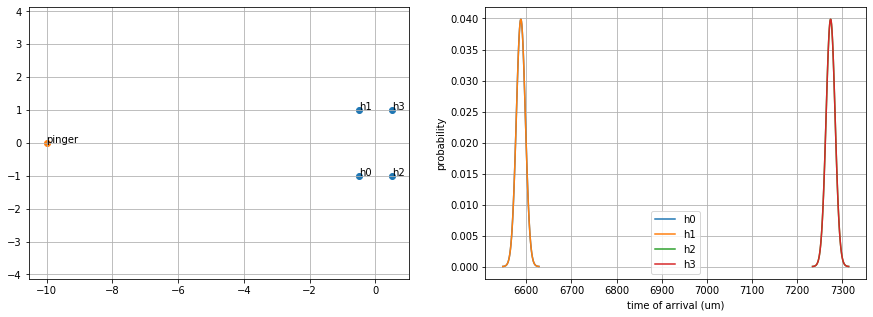

In [112]:
HYDRO_SIZE = (0.5, 1.0)
PINGER = (-10, 0)
#this actually depends on the water composition, estimate in m/us
SOUND_VELOCITY = 0.00145
#standard deviation of measured times in microseconds
NOISE_STD = 10

hydros_x = [-HYDRO_SIZE[0], -HYDRO_SIZE[0], HYDRO_SIZE[0], HYDRO_SIZE[0]]
hydros_y = [-HYDRO_SIZE[1], HYDRO_SIZE[1], -HYDRO_SIZE[1], HYDRO_SIZE[1]]

#plot out the scenario of hydrophones and pinger
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(1, 2)
ax[0].grid(True)
ax[0].axis('equal')
ax[0].scatter(hydros_x, hydros_y)
for i in range(0, 4):
    ax[0].annotate("h" + str(i), (hydros_x[i], hydros_y[i]))
    
ax[0].scatter(PINGER[0], PINGER[1])
ax[0].annotate("pinger", (PINGER[0], PINGER[1]))

#show distributions of arrival times in context
tm = [0, 0, 0, 0]
for i in range(0, 4):
    #find true time (in um)
    tm[i] = math.sqrt((hydros_x[i] - PINGER[0])**2 + (hydros_y[i] - PINGER[1])**2) / SOUND_VELOCITY
    dom = np.linspace(tm[i] - 4 * NOISE_STD, tm[i] + 4 * NOISE_STD, 100)
    ax[1].plot(dom, norm.pdf(dom, tm[i], NOISE_STD), label='h' + str(i))
    
ax[1].legend()
ax[1].set_xlabel('time of arrival (um)')
ax[1].set_ylabel('probability')
ax[1].grid(True)

For optimization purposes, we use a plane wave approximation. This has the helpful property of turning our transfer function from heading to time deltas into a linear transformation. We use a least squares error function on our three deltas (assuming h0 is at 0 us) and optimize while constraining the domain to a unit vector.

The full function to be minimized is as follows:

Where $h_n$ is the position of the hydrophone relative to origin, $\vec{o}$ is the observed time from each non-zero hydrophone, $\hat{x}$ is the unit vector pointing toward the pinger, and $v$ is the speed of sound,


$$A = \frac{-1}{v} \begin{bmatrix} h_{1} - h_{0} & h_{2} - h_{0} & h_{3} - h_{0} \end{bmatrix} ^ T$$
$$f(\hat{x}) = \begin{Vmatrix} (A\hat{x} - \vec{o}) \end{Vmatrix}^2$$

A good way of interpreting it is that $f(\hat{x})$ reaches a minimal value when the heading provides the closest approximation of the observed times, assuming some simplifications. For optimizing, the gradient can be numerically determined, but in our case we can achieve greater accuracy since $\nabla f(\hat{x})$ can be written in closed form as:

$$\nabla f(\hat{x}) = 2(A\hat{x}-\vec{o})^T \cdot A$$

In [113]:
#construct matrix for transformation between unit length heading and time deltas
h1vec = [hydros_x[1] - hydros_x[0], hydros_y[1] - hydros_y[0]]
h2vec = [hydros_x[2] - hydros_x[0], hydros_y[2] - hydros_y[0]]
h3vec = [hydros_x[3] - hydros_x[0], hydros_y[3] - hydros_y[0]]
trans = np.array([h1vec, h2vec, h3vec])
#scale matrix by velocity so that results are in us
trans *= (-1 / SOUND_VELOCITY)

#print with fancy LaTeX
sympy.init_printing()
sympy.Matrix(trans)

⎡       0.0         -1379.31034482759⎤
⎢                                    ⎥
⎢-689.655172413793         0.0       ⎥
⎢                                    ⎥
⎣-689.655172413793  -1379.31034482759⎦

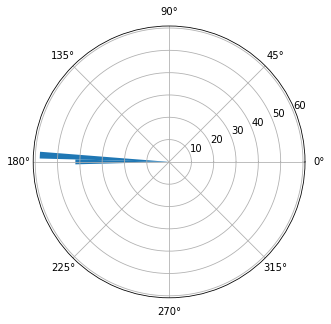

In [114]:
def heading_to_deltas(x, o):
    finalvec = np.dot(trans, x) - o
    return finalvec[0]**2 + finalvec[1]**2 + finalvec[2]**2

def gradient(x, o):
    finalvec = np.dot(trans, x) - o
    return np.dot(np.transpose(finalvec * 2), trans)

def constraint(x):
    return x[0]**2 + x[1]**2

SAMPLE_NUM = 100

samples = np.empty((SAMPLE_NUM, 2))

ideal_observed = np.array([tm[1] - tm[0], tm[2] - tm[0], tm[3] - tm[0]])

for i in range(0, SAMPLE_NUM):
    mod = (NOISE_STD * np.random.randn(4)) + tm

    observed = np.array([mod[1] - mod[0], mod[2] - mod[0], mod[3] - mod[0]])

    #inputs are constrained to the unit circle
    con = optimize.NonlinearConstraint(constraint, 1, 1)

    result = optimize.minimize(fun=heading_to_deltas, x0=np.array([0, 1]), args=(observed,),
                             method='trust-constr', jac=gradient, constraints=con)
    
    samples[i] = result.x

headings = np.arctan2(samples[:,1:2], samples[:,:1])
for i in range(0, SAMPLE_NUM):
    if headings[i] < 0:
        headings[i] = 2 * np.pi + headings[i]
        
bins_number = 120  # the [0, 360) interval will be subdivided into this
# number of equal bins
bins = np.linspace(0.0, 2 * np.pi, bins_number + 1)
n, _, _ = plt.hist(headings, bins)

plt.clf()
width = 2 * np.pi / bins_number
ax = plt.subplot(1, 1, 1, projection='polar')
bars = ax.bar(bins[:bins_number], n, width=width, bottom=0.0)
plt.show()

The above graph is a histogram of solved headings baed on the distribution of times above.